In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.measure import regionprops, label
import re
import pandas as pd
from tempfile import TemporaryFile

In [2]:
# load in file
def load_img(filename):
    itkimage = sitk.ReadImage(filename)
    numpy_image = sitk.GetArrayFromImage(itkimage) # z, y, x...
#     numpy_image = np.swapaxes(numpy_image, 0, 2)
    numpy_origin = np.array(itkimage.GetOrigin()) # x, y, z...
    numpy_spacing = np.array(itkimage.GetSpacing())
    return numpy_image, numpy_origin, numpy_spacing

# normalize method
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean)/std

# show distribution
def distribution(normalize_img):
    plt.hist(normalize_img.flatten(), bins = 200)
    plt.show()

# this one has strange distribution, not as cleanly separated
# img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd')
# distribution(normalize(img))

# this was the one with the slice with a black circular border, seems to not be different in 3d dist
# img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
# distribution(normalize(img))

# this was a normal one without black border
# img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')
# distribution(normalize(img))

In [3]:
# proceed with k-means with k = 2 or k = 3, depending on if outliers exist
def convert_binary(norm_img):
    minimum = np.min(norm_img)
    num_near_min = norm_img[norm_img - minimum < 0.01].shape[0]
    total_count = norm_img.flatten().shape[0]
    if num_near_min/total_count > 0.1:
        print('hi3')
        kmeans = KMeans(n_clusters = 3, random_state = 0, n_init = 2, max_iter = 5).fit(norm_img.flatten().reshape(-1, 1))
    else:
        print('hi2')
        kmeans = KMeans(n_clusters = 2, random_state = 0, n_init = 1, max_iter = 1).fit(norm_img.flatten().reshape(-1, 1))
    print('bye')
    centers = np.sort(kmeans.cluster_centers_.flatten())
    if centers.shape[0]==3:
        thresh_1 = (centers[0] + centers[1]) / 2
#         print(thresh_1)
        thresh_2 = (centers[1] + centers[2]) / 2
#         print(thresh_2)
        bin_img = np.where((norm_img < thresh_2) & (norm_img > thresh_1), 1.0, 0.0)
    else:
        thresh = (centers[0] + centers[1]) / 2
        bin_img = np.where(norm_img < thresh, 1.0, 0.0)
#     plt.imshow(bin_img[int(0.5*bin_img.shape[0]), 0:512, 0:512])
    return bin_img
    
# this is the noisiest image
# img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')
# bin_img = convert_binary(normalize(img))   

In [4]:
# bi = np.copy(bin_img)
# plt.imshow(bi[int(0.5*bi.shape[0]), 0:512, 0:512])

In [5]:
# erode/dilate to get clean regions 
def make_regions(bin_img):
    for s in range(bin_img.shape[0]):
        s1 = bin_img[s,:,:]
        s2 = binary_erosion(s1, selem = np.ones([2, 2]))
        bin_img[s,:,:] = binary_dilation(s2, selem = np.ones([8, 8]))
#     plt.imshow(bin_img[int(0.5*bin_img.shape[0]), 0:512, 0:512])
    return bin_img
    
# x = make_regions(bi)

In [6]:
# make the mask from the regions
def make_mask(reg_img):
    mask = np.zeros(reg_img.shape)
    for s in range(reg_img.shape[0]):
        s1 = reg_img[s,:,:]
        props = regionprops(label(s1))
        labels = []
        for p in props:
            B = p.bbox
            if B[0] > 10 and B[2] < 500 and B[1] > 10 and B[3] < 500 and B[2] - B[0] > 50 and B[3] - B[1] > 50:
                labels.append(p.label)
        for l in labels:
            mask[s, :, :] = mask[s, :, :] + np.where(label(s1) == l, 1, 0)
#     plt.imshow(mask[int(mask.shape[0]*0.5), 0:512, 0:512])
    return mask

# m = make_mask(x)

In [7]:
# apply the mask and normalize the img based on useful values
def mask_on_orig(original, mask):
    new_img = original * mask
    
    mean = np.mean(original[mask > 0])
    std = np.std(original[mask > 0])
    new_img = (new_img - mean)/std
    new_img[mask==0] = -5 # background = mean - 5 * std before normalization, highly unlikely to interfere
    
#     plt.imshow(new_img[int(new_img.shape[0] * 0.5), 0:512, 0:512])
#     plt.show()
#     plt.hist(new_img.flatten(), bins=200)
    
    return new_img

# img, origin, spacing = load_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')
# mask_on_orig(img, m)

In [8]:
# using previous methods to process through one whole image

def process_img(filename):
    img, origin, spacing = load_img(filename)
    print(filename)
    norm_img = normalize(img)
    bin_img = convert_binary(norm_img)
    reg_img = make_regions(bin_img)
    mask = make_mask(reg_img)
    masked_img = mask_on_orig(img, mask)
    
#     plt.imshow(masked_img[int(masked_img.shape[0] * 0.5), 0:512, 0:512])
#     plt.show()
#     plt.hist(masked_img.flatten(), bins=200)
    
    return masked_img, origin, spacing

# process_img('/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd')

In [14]:
# process all files with .mhd file ext in a directory, save images to a new directory

def process_dir(d, out_dir, out_meta = '/Users/kanetian7/LUNA16/data/meta.csv'):
    os.makedirs(out_dir, 0o755, exist_ok = True)
    originsZ = []
    originsY = []
    originsX = []
    spacingsZ = []
    spacingsY = []
    spacingsX = []
    names = []
    zDim = []
    yDim = []
    xDim = []
    df = pd.read_csv(out_meta)
    for file in os.listdir(d):
        if re.search('.mhd$', file):
            img, origin, spacing = process_img(d + file)
            img.tofile(out_dir + 'p_' + re.split('.mhd$', file)[0] + '.txt', sep = ',')
            originsZ.append(origin[2])
            originsY.append(origin[1])
            originsX.append(origin[0])
            spacingsZ.append(spacing[2])
            spacingsY.append(spacing[1])
            spacingsX.append(spacing[0])
            zDim.append(img.shape[0])
            yDim.append(img.shape[1])
            xDim.append(img.shape[2])
            names.append(re.split('.mhd$', file)[0])
            print('done')
    new = pd.DataFrame({'Name': names, 'OriginZ': originsZ, 'OriginY': originsY, 'OriginX': originsX,
                        'SpacingZ': spacingsZ, 'SpacingY': spacingsY, 'SpacingX': spacingsX, 'zDim': zDim, 'yDim': yDim, 'xDim': xDim})
    df = pd.concat([df, new], axis = 0).reset_index(drop=True)
    df.to_csv(out_meta)
    
process_dir('/Users/kanetian7/LUNA16/data/subset0/', '/Users/kanetian7/LUNA16/data/processed0/')

/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
hi2
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
hi2
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
hi3
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
hi3
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
hi3
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
hi3
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
hi3
bye
done
/Users/kanetian7/LUNA16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
hi3
bye
done


In [44]:
# img, o, s = load_img('/Users/kanetian7/LUNA16/data/processed0/p_1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd')
# print(o)
# np.array([ [[1.12142412, 2, 3], [4., 5.124121, 6]], [[1, 2, 3], [4, 9, 0]] ]).tofile('/Users/kanetian7/LUNA16/a.txt', sep = ',')
x = np.fromfile('/Users/kanetian7/LUNA16/data/processed0/p_1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.txt', sep = ',')

In [45]:
meta = pd.read_csv('/Users/kanetian7/LUNA16/data/meta.csv')
zDim = meta[meta['Name']=='1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354']['zDim'].iloc[0]
print(zDim)

672


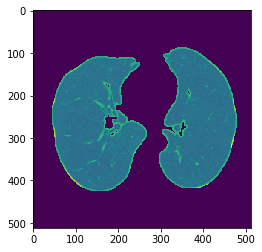

In [46]:
x = x.reshape((zDim, 512, 512))
img = x[int(zDim * 0.5), 0:512, 0:512]
plt.imshow(img)